## 5.4 단순한 계층 구현하기
### 5.4.1 곱셈 계층

In [1]:
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None
    
    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x * y
        
        return out
    
    def backward(self, dout):
        dx = dout * self.y # x와 y를 바꾼다.
        dy = dout * self.x
        
        return dx, dy

In [2]:
apple = 100
apple_num = 2
tax = 1.1

# 계층들
mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

# 순전파
apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

print(price)

220.00000000000003


In [3]:
# 역전파
dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(dapple, dapple_num, dtax)

# backward()가 받는 인수는 '순전파의 출력에 대한 미분'이다.

2.2 110.00000000000001 200


### 5.4.2 덧셈 계층

In [4]:
class AddLayer:
    def __init__(self):
        pass
    
    def forward(self, x, y):
        out = x + y
        return out
    
    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1
        return dx, dy

In [5]:
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

# 계층들
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

# 순전파
apple_price = mul_apple_layer.forward(apple, apple_num)
orange_price = mul_orange_layer.forward(orange, orange_num)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)
price = mul_tax_layer.forward(all_price, tax)

# 역전파
dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(price)
print(dapple_num, dapple, dorange, dorange_num, dtax)

715.0000000000001
110.00000000000001 2.2 3.3000000000000003 165.0 650


## 5.5 활성화 함수 계층 구현하기
### 5.5.1 ReLU 계층

In [6]:
class Relu:
    def __init__(self):
        self.mask = None
    
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        
        return dx

In [7]:
import numpy as np

x = np.array( [[1.0, -0.5], [-2.0, 3.0]])
print(x)
mask = (x <= 0)
print(mask)

[[ 1.  -0.5]
 [-2.   3. ]]
[[False  True]
 [ True False]]


In [8]:
class Sigmoid:
    def __init__(self):
        self.out = None
    
    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        
        return out
    
    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        
        return dx

## 5.6 Affine/Softmax 계층 구현하기
### 5.6.2 배치용 Affine 계층

In [9]:
X_dot_W = np.array([[0,0,0], [10,10,10]])
B = np.array([1,2,3])
print(X_dot_W)
print(X_dot_W + B)

[[ 0  0  0]
 [10 10 10]]
[[ 1  2  3]
 [11 12 13]]


In [10]:
dY = np.array([[1,2,3], [4,5,6]])
print(dY)
dB = np.sum(dY, axis=0)
print(dB)

[[1 2 3]
 [4 5 6]]
[5 7 9]


In [11]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
    
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        
        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        return dx

### 5.6.3 Softmax-with-Loss 계층

In [13]:
def softmax(a):
    c = np.max(a)
    exp_a = np.exp(a - c) # 오버플로 대책
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a
    return y

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [12]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실
        self.y = None    # softmax의 출력
        self.t = None    # 정답 레이블(원-핫 벡터)
    
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        
        return dx

## 5.7 오차역전파법 구현하기
### 5.7.2 오차역전파법을 적용한 신경망 구현하기

In [17]:
import sys, os
import numpy as np

from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict

class TwoLayerNet:
    
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        
        self.lastLayer = SoftmaxWithLoss()
    
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
    
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        
        return accuracy
    
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        return grads
    
    def gradient(self, x, t):
        # 순전파
        self.loss(x, t)
        
        # 역전파
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        
        # 결과 저장
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db
        
        return grads

### 5.7.3 오차역전파법으로 구한 기울기 검증하기

In [18]:
import sys, os
sys.path.append(os.pardir)
from mnist import load_mnist

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

# 각 가중치 차이의 절댓값을 구한 후, 그 절댓값들의 평균을 낸다.
for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(key + ":" + str(diff))

W1:4.88829729601166e-07
b1:1.0400422718534395e-05
W2:8.444742395105003e-09
b2:1.4011115755385718e-07


### 5.7.4 오차역전파법을 사용한 학습 구현하기

In [25]:
# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 오차역전파법으로 기울기를 구한다.
    grad = network.gradient(x_batch, t_batch)
    
    # 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print('Epoch', str(int(i//iter_per_epoch)), ':', train_acc, test_acc)

Epoch 0 : 0.1083 0.1197
Epoch 1 : 0.9053333333333333 0.9075
Epoch 2 : 0.9223666666666667 0.9253
Epoch 3 : 0.9358333333333333 0.9356
Epoch 4 : 0.9445333333333333 0.9429
Epoch 5 : 0.9522166666666667 0.9513
Epoch 6 : 0.9572833333333334 0.9538
Epoch 7 : 0.9615 0.9575
Epoch 8 : 0.9637 0.9593
Epoch 9 : 0.9659666666666666 0.9611
Epoch 10 : 0.96995 0.9637
Epoch 11 : 0.9705833333333334 0.9638
Epoch 12 : 0.9739833333333333 0.9661
Epoch 13 : 0.9749833333333333 0.9659
Epoch 14 : 0.9767666666666667 0.9675
Epoch 15 : 0.9755666666666667 0.9662
Epoch 16 : 0.9782666666666666 0.9679


Text(0.5, 0, 'iteration')

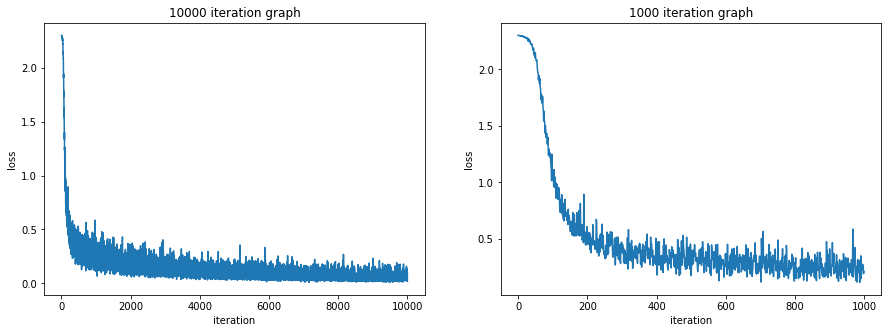

In [38]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(figsize=(15, 5), nrows=1, ncols=2)

axs[0].set_title('10000 iteration graph')
axs[0].plot(train_loss_list)
axs[0].set_ylabel('loss')
axs[0].set_xlabel('iteration')

axs[1].set_title('1000 iteration graph')
axs[1].plot(train_loss_list[:1000])
axs[1].set_ylabel('loss')
axs[1].set_xlabel('iteration')

Text(0, 0.5, 'accuracy')

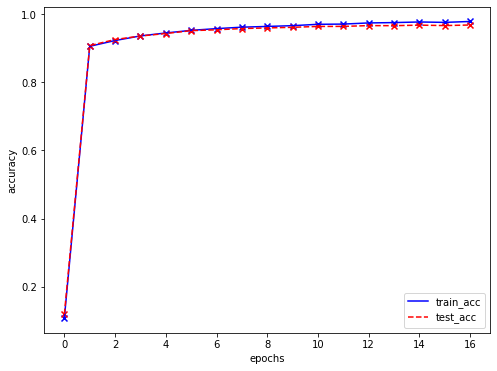

In [63]:
plt.figure(figsize=(8, 6))
plt.plot(train_acc_list, linestyle='-', c='b', label='train_acc')
plt.scatter(x=range(17), y=train_acc_list, c='b', marker='x')
plt.plot(test_acc_list, linestyle='--', c='r', label='test_acc')
plt.scatter(x=range(17), y=test_acc_list, c='r', marker='x')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')